In [2]:
import numpy as np
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

## Single Example

In [137]:
N = 20
M = 50
sigma = 0.1                 # Corresponding to 20dB

# Generate fixed H (measurement matrix)
H = np.random.normal(0, 1, size=(N, M))

# Generate a single sparse x
x_true = np.zeros(M)
non_zero_indices = np.random.choice(M, size=M//10, replace=False)
x_true[non_zero_indices] = np.random.normal(0, 1, size=M//10)

# Generate observed Y with Gaussian noise
noise = np.random.normal(0, sigma, N)
Y = H @ x_true + noise  # Single observed data point

stan_data = {
    "N": N,
    "M": M,
    "Y": Y,
    "H": H,
    "sigma": sigma,
}


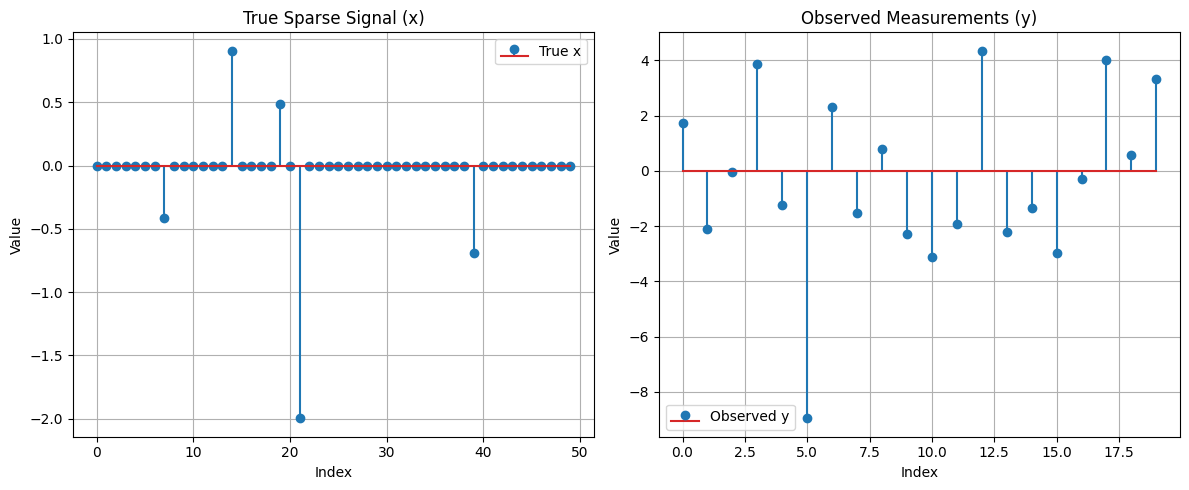

In [138]:
# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plot x_true
plt.subplot(1, 2, 1)
plt.stem(range(M), x_true, label='True x')
plt.title('True Sparse Signal (x)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Plot y
plt.subplot(1, 2, 2)
plt.stem(range(N), Y, label='Observed y')
plt.title('Observed Measurements (y)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [198]:

model = CmdStanModel(stan_file="latent.stan")
fit = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000, max_treedepth=20, step_size=0.05, adapt_delta=0.9)

posterior_samples = fit.draws_pd()
mean_x = np.array((posterior_samples.filter(like='x').mean()))
std_x = np.array((posterior_samples.filter(like='x').std()))

15:28:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status
























chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:07 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:07 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:07 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:07 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████▉    | 00:08 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▊   | 00:08 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▎  | 00:09 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |███████▋  | 00:09 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |████████▏ | 00:09 Iteration: 1500 / 2000 [ 75%]  (Sampl


15:28:21 - cmdstanpy - INFO - CmdStan done processing.
15:28:21 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 3 had 14 divergent transitions (1.4%)
	Chain 4 had 10 divergent transitions (1.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [199]:
# Set pandas display options to show all rows and columns
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Display the complete summary
print(fit.summary())

# Optional: Reset display options to default after viewing
pd.reset_option('all')

                        Mean         MCSE         StdDev          5%  \
lp__              147.477000     0.676932      12.732500  125.590000   
x[1]               -0.001782     0.001296       0.033366   -0.057379   
x[2]               -0.010172     0.001794       0.039587   -0.084788   
x[3]                0.010861     0.001720       0.046882   -0.043997   
x[4]                0.005204     0.001767       0.044809   -0.057797   
x[5]                0.002647     0.001095       0.028185   -0.038267   
x[6]                0.011132     0.001159       0.030859   -0.023973   
x[7]                0.000700     0.001243       0.034009   -0.050912   
x[8]               -0.404850     0.002243       0.059443   -0.498686   
x[9]               -0.019767     0.001686       0.038151   -0.098183   
x[10]              -0.002592     0.001613       0.041131   -0.068978   
x[11]               0.001680     0.001041       0.030412   -0.041717   
x[12]              -0.001909     0.000984       0.026704   -0.04

/var/folders/cz/m0yy93q13flbm67m6wwr1ygh0000gn/T/ipykernel_52100/2147477306.py:12: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
/var/folders/cz/m0yy93q13flbm67m6wwr1ygh0000gn/T/ipykernel_52100/2147477306.py:12: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


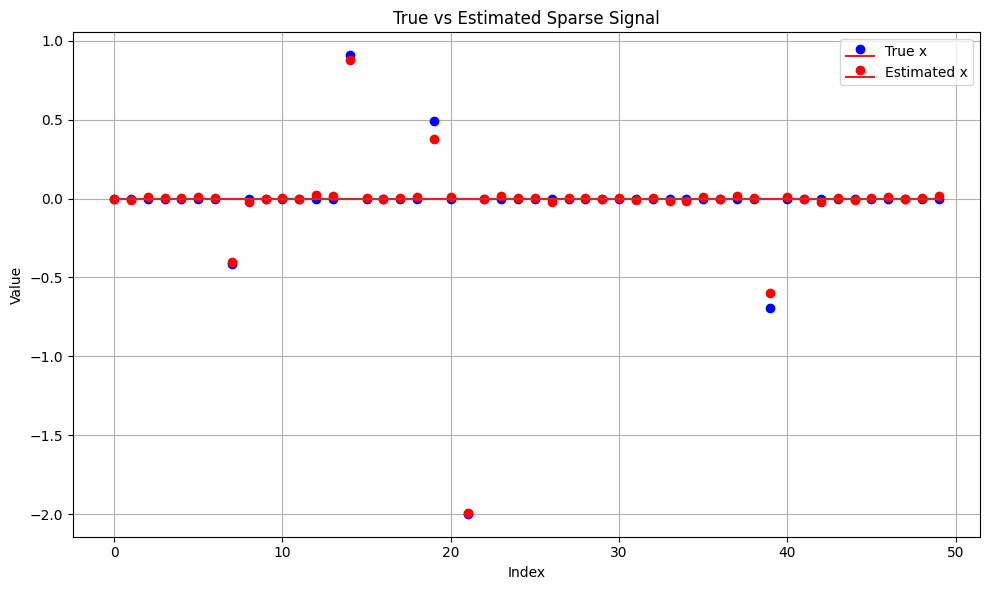

In [200]:
# Create a figure
plt.figure(figsize=(10, 6))

# Plot true x values (use 'None' for linefmt to remove vertical lines)
plt.stem(range(M), x_true, label='True x', linefmt='None', markerfmt='bo')

# Plot estimated x values (use 'None' for linefmt to remove vertical lines)
plt.stem(range(M), mean_x, label='Estimated x', linefmt='None', markerfmt='ro')

plt.title('True vs Estimated Sparse Signal')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [201]:
norm_diff_squared = np.sum((x_true - mean_x)**2)
norm_x_squared = np.sum(x_true**2)
NMSE = norm_diff_squared / norm_x_squared

NMSE

0.00456419938898615

## Generalized

In [202]:
snr_ranges = list(range(0,31,5))

sigma_list = []

for snr in snr_ranges:
    sigma_sq = 10**(-snr/10)
    sigma = sigma_sq**0.5
    sigma_list.append(sigma)

sigma_list

[1.0,
 0.5623413251903491,
 0.31622776601683794,
 0.17782794100389226,
 0.1,
 0.05623413251903491,
 0.03162277660168379]

In [203]:
def get_nmse(N, M, sigma):
    
    # Generate fixed H (measurement matrix)
    H = np.random.normal(0, 1, size=(N, M))

    # Generate a single sparse x
    x_true = np.zeros(M)
    non_zero_indices = np.random.choice(M, size=M//10, replace=False)
    x_true[non_zero_indices] = np.random.normal(0, 1, size=M//10)

    # Generate observed Y with Gaussian noise
    noise = np.random.normal(0, sigma, N)
    Y = H @ x_true + noise  # Single observed data point

    stan_data = {
        "N": N,
        "M": M,
        "Y": Y,
        "H": H,
        "sigma": sigma,
    }

    model = CmdStanModel(stan_file="latent.stan")
    # fit = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000, max_treedepth=15)
    fit = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000, max_treedepth=20, step_size=0.05, adapt_delta=0.9)


    posterior_samples = fit.draws_pd()
    mean_x = np.array((posterior_samples.filter(like='x').mean()))
    std_x = np.array((posterior_samples.filter(like='x').std()))

    norm_diff_squared = np.sum((x_true - mean_x)**2)
    norm_x_squared = np.sum(x_true**2)
    NMSE = norm_diff_squared / norm_x_squared


    return NMSE
    


In [204]:
NMSE_mean_dict = {}
NMSE_max_dict = {}
NMSE_min_dict = {}

for i in range(len(snr_ranges)):
    nmse_values = []
    K = 10                              # The no. of iterations u want to run for!
    for iter in range(K):
        nmse_values.append(get_nmse(N=20, M=50, sigma=sigma_list[i]))
    NMSE_mean_dict[snr_ranges[i]] = np.mean(nmse_values)
    NMSE_max_dict[snr_ranges[i]] = np.max(nmse_values)
    NMSE_min_dict[snr_ranges[i]] = np.min(nmse_values)

15:30:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:05 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:10 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:12 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:12 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:13 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:14 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:15 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:16 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:17 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:18 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:19 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |


15:30:55 - cmdstanpy - INFO - CmdStan done processing.
15:30:55 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 29 divergent transitions (2.9%)
	Chain 2 had 9 divergent transitions (0.9%)
	Chain 3 had 41 divergent transitions (4.1%)
	Chain 4 had 22 divergent transitions (2.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:30:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |▉         | 00:05 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:09 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:10 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:10 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:11 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:12 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:12 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:13 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:14 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:15 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:16 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:16 Iteration: 1300 / 2000 [ 65%]  (Sampling)


c


15:31:19 - cmdstanpy - INFO - CmdStan done processing.
15:31:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 20 divergent transitions (2.0%)
	Chain 2 had 28 divergent transitions (2.8%)
	Chain 3 had 71 divergent transitions (7.1%)
	Chain 4 had 61 divergent transitions (6.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:31:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:05 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:10 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:11 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:12 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:13 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:13 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:14 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:15 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:16 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:16 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:17 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |██


15:31:51 - cmdstanpy - INFO - CmdStan done processing.
15:31:51 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 59 divergent transitions (5.9%)
	Chain 2 had 55 divergent transitions (5.5%)
	Chain 3 had 44 divergent transitions (4.4%)
	Chain 4 had 5 divergent transitions (0.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:31:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)






chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:10 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:12 Iteration:  300 / 2000 [ 15%]  (Warmup)





chain 1 |██▋       | 00:13 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:14 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:15 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████      | 00:16 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:16 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:17 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:17 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:18 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:18 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |███████▎  | 00:19 Iteration: 1300 / 2000 


15:32:15 - cmdstanpy - INFO - CmdStan done processing.
15:32:15 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 147 divergent transitions (14.7%)
	Chain 2 had 19 divergent transitions (1.9%)
	Chain 3 had 33 divergent transitions (3.3%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:32:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:05 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:10 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:11 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:12 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:13 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:14 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:14 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:15 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:16 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:17 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:17 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 


15:32:39 - cmdstanpy - INFO - CmdStan done processing.
15:32:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 59 divergent transitions (5.9%)
	Chain 2 had 18 divergent transitions (1.8%)
	Chain 3 had 28 divergent transitions (2.8%)
	Chain 4 had 49 divergent transitions (4.9%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:32:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)





chain 1 |█▊        | 00:10 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:11 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:12 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:13 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███▋      | 00:14 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:14 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:15 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:16 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:16 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:17 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:18 Iteration: 1200 / 2000 [ 60%]  (Samplin


15:33:03 - cmdstanpy - INFO - CmdStan done processing.
15:33:03 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 40 divergent transitions (4.0%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 84 divergent transitions (8.4%)
	Chain 4 had 18 divergent transitions (1.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:33:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status










chain 1 |▉         | 00:08 Iteration:    1 / 2000 [  0%]  (Warmup)








chain 1 |█▎        | 00:10 Iteration:  100 / 2000 [  5%]  (Warmup)





chain 1 |█▊        | 00:11 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:11 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:12 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:12 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:13 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:13 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:14 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:15 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:15 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:16 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:16 Iteration: 1200 / 2000 [ 60%]  (S


15:33:24 - cmdstanpy - INFO - CmdStan done processing.
15:33:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 17 divergent transitions (1.7%)
	Chain 2 had 34 divergent transitions (3.4%)
	Chain 3 had 8 divergent transitions (0.8%)
	Chain 4 had 22 divergent transitions (2.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:33:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:10 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:11 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:12 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███▋      | 00:12 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:14 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:14 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:15 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:16 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:17 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:17 Iteration: 1200 / 2000 [ 60%]  (Sampling)


cha


15:33:47 - cmdstanpy - INFO - CmdStan done processing.
15:33:47 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 2 had 34 divergent transitions (3.4%)
	Chain 3 had 28 divergent transitions (2.8%)
	Chain 4 had 58 divergent transitions (5.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:33:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:10 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:11 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:12 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:13 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:14 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:14 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:15 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:16 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:17 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:17 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |███


15:34:13 - cmdstanpy - INFO - CmdStan done processing.
15:34:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 65 divergent transitions (6.5%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 34 divergent transitions (3.4%)
	Chain 4 had 12 divergent transitions (1.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:34:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)










chain 1 |█▎        | 00:09 Iteration:  100 / 2000 [  5%]  (Warmup)





chain 1 |██▎       | 00:12 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:13 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:14 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:15 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:16 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:17 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:19 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:19 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:20 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▎  | 00:21 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |███████▋  | 00:22 Iteration: 1400 / 2000 [ 70%]  (Sampli


15:34:42 - cmdstanpy - INFO - CmdStan done processing.
15:34:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 38 divergent transitions (3.8%)
	Chain 2 had 7 divergent transitions (0.7%)
	Chain 3 had 18 divergent transitions (1.8%)
	Chain 4 had 15 divergent transitions (1.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:34:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:05 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:06 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:07 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:08 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:08 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:10 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:10 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:11 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:11 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:12 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:13 Iteration: 1200 / 2000 [ 60%]  (Sampling)




cha


15:35:00 - cmdstanpy - INFO - CmdStan done processing.
15:35:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 34 divergent transitions (3.4%)
	Chain 2 had 65 divergent transitions (6.5%)
	Chain 3 had 42 divergent transitions (4.2%)
	Chain 4 had 8 divergent transitions (0.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:35:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:07 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:09 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:10 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:10 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:11 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:11 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:11 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:12 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:13 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:13 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:14 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████


15:35:21 - cmdstanpy - INFO - CmdStan done processing.
15:35:21 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (0.8%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 20 divergent transitions (2.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:35:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status










chain 1 |▉         | 00:09 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:09 Iteration:  100 / 2000 [  5%]  (Warmup)






chain 1 |█▊        | 00:11 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:12 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:12 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:13 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:14 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:15 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:15 Iteration:  800 / 2000 [ 40%]  (Warmup)





chain 1 |█████     | 00:16 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:16 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:17 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:17 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |███████▎  | 00:18 Iteration: 1300 /


15:35:43 - cmdstanpy - INFO - CmdStan done processing.
15:35:43 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 16 divergent transitions (1.6%)
	Chain 2 had 21 divergent transitions (2.1%)
	Chain 3 had 45 divergent transitions (4.5%)
	Chain 4 had 22 divergent transitions (2.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:35:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:04 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:07 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:08 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:10 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:10 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:11 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████▌     | 00:11 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:12 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:12 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:13 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:13 Iteration: 1200 / 2000 [ 60%]  (Sampling)



15:36:03 - cmdstanpy - INFO - CmdStan done processing.
15:36:03 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 59 divergent transitions (5.9%)
	Chain 2 had 52 divergent transitions (5.2%)
	Chain 3 had 66 divergent transitions (6.6%)
	Chain 4 had 53 divergent transitions (5.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:36:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status












chain 1 |▉         | 00:08 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:09 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:10 Iteration:  200 / 2000 [ 10%]  (Warmup)





chain 1 |██▎       | 00:11 Iteration:  300 / 2000 [ 15%]  (Warmup)





chain 1 |██▋       | 00:12 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:12 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |███▋      | 00:13 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:13 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:14 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:14 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:15 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:15 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |███████▎  | 00:16 Iteration: 1300 / 2000 [ 65%


15:36:21 - cmdstanpy - INFO - CmdStan done processing.
15:36:21 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 70 divergent transitions (7.0%)
	Chain 2 had 18 divergent transitions (1.8%)
	Chain 3 had 14 divergent transitions (1.4%)
	Chain 4 had 33 divergent transitions (3.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:36:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status












chain 1 |▉         | 00:08 Iteration:    1 / 2000 [  0%]  (Warmup)






chain 1 |█▎        | 00:09 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:10 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:10 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:11 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:11 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:12 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:12 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:13 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:13 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:14 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:14 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:14 It


15:36:38 - cmdstanpy - INFO - CmdStan done processing.
15:36:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 22 divergent transitions (2.2%)
	Chain 2 had 61 divergent transitions (6.1%)
	Chain 4 had 36 divergent transitions (3.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:36:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:06 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:07 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:08 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:10 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:10 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:11 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:11 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:12 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:13 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:14 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |███████▎  | 00:15 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |███████▋  | 00:16 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain


15:37:01 - cmdstanpy - INFO - CmdStan done processing.
15:37:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 9 divergent transitions (0.9%)
	Chain 2 had 12 divergent transitions (1.2%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 3 divergent transitions (0.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:37:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:10 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:11 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:12 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:12 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████      | 00:12 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:13 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:14 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:14 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:14 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:15 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 


15:37:21 - cmdstanpy - INFO - CmdStan done processing.
15:37:21 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 20 divergent transitions (2.0%)
	Chain 2 had 2 divergent transitions (0.2%)
	Chain 3 had 125 divergent transitions (12.5%)
	Chain 4 had 2 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:37:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:09 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:10 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:11 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:11 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:11 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:12 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:12 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:13 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:13 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |


15:37:39 - cmdstanpy - INFO - CmdStan done processing.
15:37:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 40 divergent transitions (4.0%)
	Chain 2 had 37 divergent transitions (3.7%)
	Chain 3 had 51 divergent transitions (5.1%)
	Chain 4 had 18 divergent transitions (1.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:37:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:09 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:10 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:10 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:11 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:11 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:12 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:13 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:13 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:14 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:15 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |████


15:38:02 - cmdstanpy - INFO - CmdStan done processing.
15:38:02 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 23 divergent transitions (2.3%)
	Chain 2 had 40 divergent transitions (4.0%)
	Chain 3 had 13 divergent transitions (1.3%)
	Chain 4 had 7 divergent transitions (0.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:38:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:07 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:08 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:10 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:10 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:10 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:11 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:11 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:11 Iteration: 1200 / 2000 [ 60%]  (Sampling)




ch


15:38:17 - cmdstanpy - INFO - CmdStan done processing.
15:38:17 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 18 divergent transitions (1.8%)
	Chain 2 had 31 divergent transitions (3.1%)
	Chain 3 had 9 divergent transitions (0.9%)
	Chain 4 had 42 divergent transitions (4.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:38:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:07 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:09 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:10 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:10 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:10 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:11 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:11 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |██████▎   | 00:12 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:12 Iteration: 1200 / 2000 [ 60%]  (Sampling)




15:38:33 - cmdstanpy - INFO - CmdStan done processing.
15:38:33 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 11 divergent transitions (1.1%)
	Chain 3 had 99 divergent transitions (9.9%)
	Chain 4 had 8 divergent transitions (0.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:38:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status














chain 1 |▉         | 00:08 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:10 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:10 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:10 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:10 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:11 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:11 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:12 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:12 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:13 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |███████▎  | 00:13 Iteration: 1300 / 2000 [ 65%]  (Sa


15:38:49 - cmdstanpy - INFO - CmdStan done processing.
15:38:49 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 13 divergent transitions (1.3%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 17 divergent transitions (1.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:38:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:06 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▋       | 00:07 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:08 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:09 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:09 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:09 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:10 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:10 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |███████▋  | 00:10 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:11 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:11 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chai


15:39:04 - cmdstanpy - INFO - CmdStan done processing.
15:39:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 14 divergent transitions (1.4%)
	Chain 2 had 14 divergent transitions (1.4%)
	Chain 3 had 10 divergent transitions (1.0%)
	Chain 4 had 104 divergent transitions (10.4%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:39:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:05 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:06 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:06 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:06 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:07 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:07 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:07 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:08 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:08 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:09 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:09 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:09 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |█████


15:39:18 - cmdstanpy - INFO - CmdStan done processing.
15:39:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 11 divergent transitions (1.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:39:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:07 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:08 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:10 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:10 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:10 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:11 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:11 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:12 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:12 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 


15:39:34 - cmdstanpy - INFO - CmdStan done processing.
15:39:34 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 88 divergent transitions (8.8%)
	Chain 3 had 22 divergent transitions (2.2%)
	Chain 4 had 8 divergent transitions (0.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:39:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:09 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:10 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:10 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:11 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:11 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:12 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:12 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:12 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:13 Iteration: 1200 / 2000 [ 60%]  (Sampling)


c


15:39:50 - cmdstanpy - INFO - CmdStan done processing.
15:39:50 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 7 divergent transitions (0.7%)
	Chain 2 had 12 divergent transitions (1.2%)
	Chain 3 had 17 divergent transitions (1.7%)
	Chain 4 had 18 divergent transitions (1.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:39:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:06 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:07 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:07 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:08 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:08 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:09 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:09 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:09 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:10 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:10 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:10 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


15:40:07 - cmdstanpy - INFO - CmdStan done processing.
15:40:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:40:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:07 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |████      | 00:08 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |█████     | 00:09 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:09 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:09 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▎  | 00:10 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:10 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |████████▏ | 00:10 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:11 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |█████████ | 00:11 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |█████████▌| 00:11 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:12 Iteration: 1900 / 2000 [ 95%]  (Sampling)





































chain 1 |██████████| 00:16 Sampling com


15:40:23 - cmdstanpy - INFO - CmdStan done processing.
15:40:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 13 divergent transitions (1.3%)
	Chain 2 had 16 divergent transitions (1.6%)
	Chain 3 had 96 divergent transitions (9.6%)
	Chain 4 had 9 divergent transitions (0.9%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:40:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:07 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)





chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:08 Iteration:  300 / 2000 [ 15%]  (Warmup)





chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:10 Iteration:  500 / 2000 [ 25%]  (Warmup)





chain 1 |███▋      | 00:10 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████      | 00:11 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |████▌     | 00:11 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:11 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:12 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 00:12 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:12 Iteration: 1200 / 2000 [ 60%]  (Sampl


15:40:39 - cmdstanpy - INFO - CmdStan done processing.
15:40:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 14 divergent transitions (1.4%)
	Chain 2 had 12 divergent transitions (1.2%)
	Chain 3 had 85 divergent transitions (8.5%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:40:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status














chain 1 |▉         | 00:07 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:08 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:09 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |████▌     | 00:09 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:10 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |█████▉    | 00:10 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |██████████| 00:12 Sampling completed                       
chain 2 |██████████| 00:12 Sampling completed       


15:40:52 - cmdstanpy - INFO - CmdStan done processing.
15:40:52 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 4 divergent transitions (0.4%)
	Chain 3 had 5 divergent transitions (0.5%)
	Chain 4 had 5 divergent transitions (0.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:40:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:06 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:06 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▋       | 00:07 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:07 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:08 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:09 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:09 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:09 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:10 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:10 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:10 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:11 Iteration: 1500 / 2000 [ 75%]  (Sampling)






15:41:07 - cmdstanpy - INFO - CmdStan done processing.
15:41:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 28 divergent transitions (2.8%)
	Chain 2 had 4 divergent transitions (0.4%)
	Chain 3 had 7 divergent transitions (0.7%)
	Chain 4 had 19 divergent transitions (1.9%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:41:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:08 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:08 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:09 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:09 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |███████▎  | 00:09 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:10 Iteration: 1400 / 2000 [ 70%]  (Sampling)





chain 1 |████████▏ | 00:10 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:11 Iteration: 1600 / 2000 [ 80%]  (Sampling)




chain 1 |█████████ | 00:11 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |█████████▌| 00:11 Iteration: 1800 / 2000 [ 90%]  (Sampling)



chain 1 |██████████| 00:11 Iteration: 1900 / 2000 [ 95%]  (Sampling)
























chain 1 |██████████| 00:14 Sampling c


15:41:22 - cmdstanpy - INFO - CmdStan done processing.
15:41:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 9 divergent transitions (0.9%)
	Chain 2 had 9 divergent transitions (0.9%)
	Chain 3 had 13 divergent transitions (1.3%)
	Chain 4 had 5 divergent transitions (0.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:41:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status






























chain 1 |▉         | 00:09 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:09 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:10 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:10 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:10 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:10 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:10 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:11 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |██████████| 00:13 Sampling completed                       
chain 2 |██████████| 00:13 Sampling completed                       
chain 3 |██████████| 00:13 Sampling completed                       
chain 4 |██████████| 00:13 Sampling completed                       


15:41:35 - cmdstanpy - INFO - CmdStan done processing.
15:41:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 6 divergent transitions (0.6%)
	Chain 4 had 22 divergent transitions (2.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:41:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:05 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:06 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:06 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:06 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:07 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:07 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███▋      | 00:07 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:08 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:08 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:09 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:09 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:09 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chai


15:41:48 - cmdstanpy - INFO - CmdStan done processing.
15:41:48 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 2 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:41:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status








chain 1 |▉         | 00:07 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:07 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:07 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:08 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:08 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:08 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:08 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:09 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:09 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |███████▎  | 00:09 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |███████▋  | 00:09 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 


15:42:02 - cmdstanpy - INFO - CmdStan done processing.
15:42:02 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 9 divergent transitions (0.9%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 2 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:42:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:07 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:07 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:07 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:08 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:08 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:08 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:09 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |███████▎  | 00:09 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |███████▋  | 00:09 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |████████▏ | 00:09 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:09 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |


15:42:14 - cmdstanpy - INFO - CmdStan done processing.
15:42:14 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 10 divergent transitions (1.0%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 2 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:42:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:07 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:07 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:07 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:08 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |████      | 00:08 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:08 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:09 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:09 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:09 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:09 Iteration: 1300 / 2000 [ 65%]  (Sampling)


ch


15:42:27 - cmdstanpy - INFO - CmdStan done processing.
15:42:27 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 3 had 10 divergent transitions (1.0%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:42:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status












chain 1 |▉         | 00:07 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:08 Iteration:  300 / 2000 [ 15%]  (Warmup)





chain 1 |██▋       | 00:08 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:09 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:09 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:10 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:10 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:10 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:10 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:10 Iteration: 1300 / 20


15:42:39 - cmdstanpy - INFO - CmdStan done processing.
15:42:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 6 divergent transitions (0.6%)
	Chain 2 had 17 divergent transitions (1.7%)
	Chain 3 had 17 divergent transitions (1.7%)
	Chain 4 had 10 divergent transitions (1.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:42:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:07 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:08 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:10 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:10 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:11 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:11 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:11 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:12 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |█


15:42:55 - cmdstanpy - INFO - CmdStan done processing.
15:42:55 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 50 divergent transitions (5.0%)
	Chain 2 had 48 divergent transitions (4.8%)
	Chain 3 had 66 divergent transitions (6.6%)
	Chain 4 had 31 divergent transitions (3.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:42:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



















chain 1 |▉         | 00:08 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:08 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:09 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:09 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:09 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:10 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:10 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:10 Iteration: 1200 / 2000 [ 60%]  (Sampling)



15:43:07 - cmdstanpy - INFO - CmdStan done processing.
15:43:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 17 divergent transitions (1.7%)
	Chain 3 had 9 divergent transitions (0.9%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:43:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status















chain 1 |▉         | 00:08 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)





chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:08 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)





chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:09 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:10 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |█████▉    | 00:10 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:10 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:10 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:12 Sampling completed      


15:43:19 - cmdstanpy - INFO - CmdStan done processing.
15:43:20 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 2 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:43:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status
















chain 1 |▉         | 00:08 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:08 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:08 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:09 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:09 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:09 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:09 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:09 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:10 Iteration: 1200 / 2000 [ 60%]  (Sampli


15:43:31 - cmdstanpy - INFO - CmdStan done processing.
15:43:31 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 14 divergent transitions (1.4%)
	Chain 3 had 5 divergent transitions (0.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:43:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




































chain 1 |▉         | 00:10 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:10 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:10 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:10 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:10 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▋      | 00:11 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |█████     | 00:11 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:11 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▊   | 00:11 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |██████████| 00:12 Sampling completed                       
chain 2 |██████████| 00:12 Sampling completed                       
chain 3 |██████████| 00:12 Sampling completed                       
chain 4 |██████████| 00:12 Sampling completed    


15:43:44 - cmdstanpy - INFO - CmdStan done processing.
15:43:44 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 7 divergent transitions (0.7%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:43:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████▉    | 00:08 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:09 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:09 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:09 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:09 Iteration: 1500 / 2000 [ 75%]  (Sampling)



chain 1 |████████▋ | 00:09 Iteration: 1600 / 2000 [ 80%]  (Sampling)



chain 1 |█████████ | 00:10 Iteration: 1700 / 2000 [ 85%]  (Sampling)



chain 1 |█████████▌| 00:10 Iteration: 1800 / 2000 [ 90%]  (Sampling)



chain 1 |██████████| 00:10 Iteration: 1900 / 2000 [ 95%]  (Sampling)















chain 1 |██████████| 00:11 Sampling completed                       
chain 2 |██████████| 00:11 Sampling completed                       
chain 3 |██████████| 00:11 Sampling completed   


15:43:56 - cmdstanpy - INFO - CmdStan done processing.
15:43:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 12 divergent transitions (1.2%)
	Chain 3 had 21 divergent transitions (2.1%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:43:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status












































chain 1 |▉         | 00:09 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:09 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:10 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:10 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |██████████| 00:12 Sampling completed                       
chain 2 |██████████| 00:12 Sampling completed                       
chain 3 |██████████| 00:12 Sampling completed                       
chain 4 |██████████| 00:12 Sampling completed                       


15:44:08 - cmdstanpy - INFO - CmdStan done processing.
15:44:08 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:44:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████████| 00:08 Iteration: 1900 / 2000 [ 95%]  (Sampling)



























































chain 1 |██████████| 00:13 Sampling completed                       
chain 2 |██████████| 00:13 Sampling completed                       
chain 3 |██████████| 00:13 Sampling completed                       
chain 4 |██████████| 00:13 Sampling completed                       


15:44:21 - cmdstanpy - INFO - CmdStan done processing.
15:44:21 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 9 divergent transitions (0.9%)
	Chain 2 had 6 divergent transitions (0.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:44:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:07 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▋      | 00:07 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:07 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:07 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:08 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:08 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:08 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:08 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▎  | 00:08 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |███████▋  | 00:08 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:09 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |████████▋ | 00:09 Iteration: 1600 / 2000 [ 80%]  (Sampling)



chain 1 |█████████ | 00:09 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:09 Iteration: 1900 / 2000 [ 95%]  (Sampling)




15:44:34 - cmdstanpy - INFO - CmdStan done processing.
15:44:34 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:44:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██▎       | 00:07 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:07 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:07 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:08 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:08 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:08 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:08 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:08 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:09 Iteration: 1300 / 2000 [ 65%]  (Sampling)




chain 1 |███████▋  | 00:09 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:09 Iteration: 1500 / 2000 [ 75%]  (Sampl


15:44:45 - cmdstanpy - INFO - CmdStan done processing.
15:44:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 12 divergent transitions (1.2%)
	Chain 3 had 21 divergent transitions (2.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:44:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status
















chain 1 |▉         | 00:07 Iteration:    1 / 2000 [  0%]  (Warmup)







chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:07 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:07 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:08 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:08 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:08 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:08 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:08 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:09 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |██████████| 00:09 Sampling completed           


15:44:55 - cmdstanpy - INFO - CmdStan done processing.
15:44:55 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:44:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status










































chain 1 |██████████| 00:11 Sampling completed                       
chain 2 |██████████| 00:11 Sampling completed                       
chain 3 |██████████| 00:11 Sampling completed                       
chain 4 |██████████| 00:11 Sampling completed                       


15:45:07 - cmdstanpy - INFO - CmdStan done processing.
15:45:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 4 divergent transitions (0.4%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:45:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |▉         | 00:08 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████▌     | 00:09 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:09 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:09 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▊   | 00:10 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:10 Iteration: 1300 / 2000 [ 65%]  (Sampling)



chain 1 |████████▏ | 00:10 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |████████▋ | 00:10 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████ | 00:10 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:11 Iteration: 1900 / 2000 [ 95%]  (Sampling)













chain 1 |██████████| 00:11 Sampling completed   


15:45:19 - cmdstanpy - INFO - CmdStan done processing.
15:45:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 14 divergent transitions (1.4%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 4 had 5 divergent transitions (0.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:45:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:07 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▋       | 00:08 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:08 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:08 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:09 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:09 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:09 Iteration: 1600 / 2000 [ 80%]  (Sampling)



chain 1 |█████████▌| 00:09 Iteration: 1800 / 2000 [ 90%]  (Sampling)






chain 1 |██████████| 00:10 Sampling completed                       
chain 2 |██████████| 00:10 Sampling completed                     


15:45:29 - cmdstanpy - INFO - CmdStan done processing.
15:45:29 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:45:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status













chain 1 |▉         | 00:09 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |██▋       | 00:10 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▋      | 00:10 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████▌     | 00:11 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████▉    | 00:11 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▊   | 00:11 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |███████▋  | 00:11 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |████████▋ | 00:11 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |█████████▌| 00:11 Iteration: 1800 / 2000 [ 90%]  (Sampling)





chain 1 |██████████| 00:12 Sampling completed                       
chain 2 |██████████| 00:12 Sampling completed                       
chain 3 |██████████| 00:12 Sampling completed                       
chain 4 |██████████| 00:12 Sampling completed                  


15:45:41 - cmdstanpy - INFO - CmdStan done processing.
15:45:41 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 8 divergent transitions (0.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:45:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:08 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:09 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████      | 00:09 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████     | 00:09 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▎   | 00:10 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |███████▎  | 00:10 Iteration: 1300 / 2000 [ 65%]  (Sampling)




chain 1 |████████▏ | 00:10 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:10 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:10 Iteration: 1900 / 2000 [ 95%]  (Sampling)













15:45:53 - cmdstanpy - INFO - CmdStan done processing.
15:45:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 3 had 31 divergent transitions (3.1%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:45:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status









































chain 1 |██████████| 00:12 Sampling completed                       
chain 2 |██████████| 00:12 Sampling completed                       
chain 3 |██████████| 00:12 Sampling completed                       
chain 4 |██████████| 00:12 Sampling completed                       


15:46:05 - cmdstanpy - INFO - CmdStan done processing.
15:46:05 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 4 had 32 divergent transitions (3.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
15:46:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status












chain 1 |▉         | 00:09 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:09 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:09 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:10 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:10 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:10 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:10 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:10 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:10 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:10 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▊   | 00:11 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:11 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |███████▋  | 00:11 Iteration: 1400 / 2000 [ 7


15:46:17 - cmdstanpy - INFO - CmdStan done processing.
15:46:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 16 divergent transitions (1.6%)
	Chain 2 had 11 divergent transitions (1.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:46:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status















chain 1 |▉         | 00:08 Iteration:    1 / 2000 [  0%]  (Warmup)







chain 1 |█▎        | 00:09 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:09 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████▌     | 00:09 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:10 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:10 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████████| 00:11 Sampling completed                       
chain 2 |██████████| 00:11 Sampling completed                       
chain 3 |██████████| 00:11 Sampling completed                       
chain 4 |██████████| 00:11 Sampling completed                


15:46:29 - cmdstanpy - INFO - CmdStan done processing.
15:46:29 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 18 divergent transitions (1.8%)
	Chain 4 had 3 divergent transitions (0.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:46:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status











chain 1 |▉         | 00:09 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |█████     | 00:10 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |██████▎   | 00:10 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |███████▎  | 00:10 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |████████▏ | 00:10 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |█████████ | 00:10 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:11 Iteration: 1900 / 2000 [ 95%]  (Sampling)











chain 1 |██████████| 00:11 Sampling completed                       
chain 2 |██████████| 00:11 Sampling completed                       
chain 3 |██████████| 00:11 Sampling completed                     


15:46:41 - cmdstanpy - INFO - CmdStan done processing.
15:46:41 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Chain 2 had 3 divergent transitions (0.3%)
	Chain 3 had 7 divergent transitions (0.7%)
	Chain 4 had 35 divergent transitions (3.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:46:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:06 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:07 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:07 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:07 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:07 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:07 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:07 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:08 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:08 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |███████▎  | 00:08 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |███████▋  | 00:08 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |████████▏ | 00:09 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |████████▋ | 00:09 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |█████████ | 00:0


15:46:55 - cmdstanpy - INFO - CmdStan done processing.
15:46:55 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 12 divergent transitions (1.2%)
	Chain 3 had 3 divergent transitions (0.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:46:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██▎       | 00:08 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:08 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████▉    | 00:08 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |███████▋  | 00:09 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:09 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |█████████▌| 00:09 Iteration: 1800 / 2000 [ 90%]  (Sampling)






















chain 1 |██████████| 00:10 Sampling completed                       
chain 2 |██████████| 00:10 Sampling completed                       
chain 3 |██████████| 00:10 Sampling completed                       
chain 4 |██████████| 00:10 Sampling completed                    


15:47:06 - cmdstanpy - INFO - CmdStan done processing.
15:47:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |███████▋  | 00:07 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |█████████▌| 00:08 Iteration: 1800 / 2000 [ 90%]  (Sampling)































chain 1 |██████████| 00:11 Sampling completed                       
chain 2 |██████████| 00:11 Sampling completed                       
chain 3 |██████████| 00:11 Sampling completed                       
chain 4 |██████████| 00:11 Sampling completed                       


15:47:17 - cmdstanpy - INFO - CmdStan done processing.
15:47:17 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Chain 3 had 2 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:47:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





























chain 1 |▉         | 00:10 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:11 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██▎       | 00:11 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |███▏      | 00:11 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |████      | 00:11 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |█████     | 00:11 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |██████████| 00:12 Sampling completed                       
chain 2 |██████████| 00:12 Sampling completed                       
chain 3 |██████████| 00:12 Sampling completed                       


chain 4 |██████████| 00:12 Sampling completed


15:47:30 - cmdstanpy - INFO - CmdStan done processing.
15:47:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 2 divergent transitions (0.2%)
	Chain 3 had 3 divergent transitions (0.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:47:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



































chain 1 |██████████| 00:11 Sampling completed                       
chain 2 |██████████| 00:11 Sampling completed                       
chain 3 |██████████| 00:11 Sampling completed                       
chain 4 |██████████| 00:11 Sampling completed                       


15:47:42 - cmdstanpy - INFO - CmdStan done processing.
15:47:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:47:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status














chain 1 |▉         | 00:08 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:08 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████▌     | 00:09 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:09 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▊   | 00:09 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▋  | 00:09 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |████████▋ | 00:09 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |█████████▌| 00:09 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:09 Sampling completed                       
chain 2 |██████████| 00:09 Sampling completed                       
ch


15:47:52 - cmdstanpy - INFO - CmdStan done processing.
15:47:52 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 3 divergent transitions (0.3%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:47:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:08 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██▎       | 00:08 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |███▏      | 00:08 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |████      | 00:09 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |██████████| 00:09 Iteration: 1900 / 2000 [ 95%]  (Sampling)



















chain 1 |██████████| 00:12 Sampling completed                       
chain 2 |██████████| 00:12 Sampling completed                       
chain 3 |██████████| 00:12 Sampling completed                       
chain 4 |██████████| 00:12 Sampling completed                       


15:48:04 - cmdstanpy - INFO - CmdStan done processing.


15:48:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:09 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:09 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:09 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████▌     | 00:09 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████▉    | 00:10 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▊   | 00:10 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▋  | 00:10 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |████████▋ | 00:10 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |█████████▌| 00:10 Iteration: 1800 / 2000 [ 90%]  (Sampling)



















chain 1 |██████████| 00:12 Sampling completed                       
chain 2 |██████████| 00:12 Sampling completed                       
chai


15:48:17 - cmdstanpy - INFO - CmdStan done processing.
15:48:17 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 3 had 6 divergent transitions (0.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:48:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status









chain 1 |▉         | 00:07 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:07 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▋       | 00:07 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:08 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████▉    | 00:08 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:08 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:08 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:08 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |█████████▌| 00:09 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:09 Sampling completed                       
chain 2 |██████████| 00:09 Sampling completed                       


15:48:27 - cmdstanpy - INFO - CmdStan done processing.
15:48:27 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 3 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


15:48:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


















chain 1 |▉         | 00:08 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:08 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:08 Iteration:  200 / 2000 [ 10%]  (Warmup)





chain 1 |███▏      | 00:08 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:09 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████▌     | 00:09 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████▉    | 00:09 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████████| 00:10 Sampling completed                       
chain 2 |██████████| 00:10 Sampling completed                       
chain 3 |██████████| 00:10 Sampling completed                       
chain 4 |██████████| 00:10 Sampling completed                       


15:48:37 - cmdstanpy - INFO - CmdStan done processing.


15:48:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |████      | 00:09 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |█████     | 00:09 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▎   | 00:09 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |███████▎  | 00:09 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▏ | 00:10 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:10 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:10 Iteration: 1900 / 2000 [ 95%]  (Sampling)











chain 1 |██████████| 00:11 Sampling completed                       
chain 2 |██████████| 00:11 Sampling completed                       
chain 3 |██████████| 00:11 Sampling completed                       
chain 4 |██████████| 00:11 Sampling completed                       


15:48:49 - cmdstanpy - INFO - CmdStan done processing.
15:48:49 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


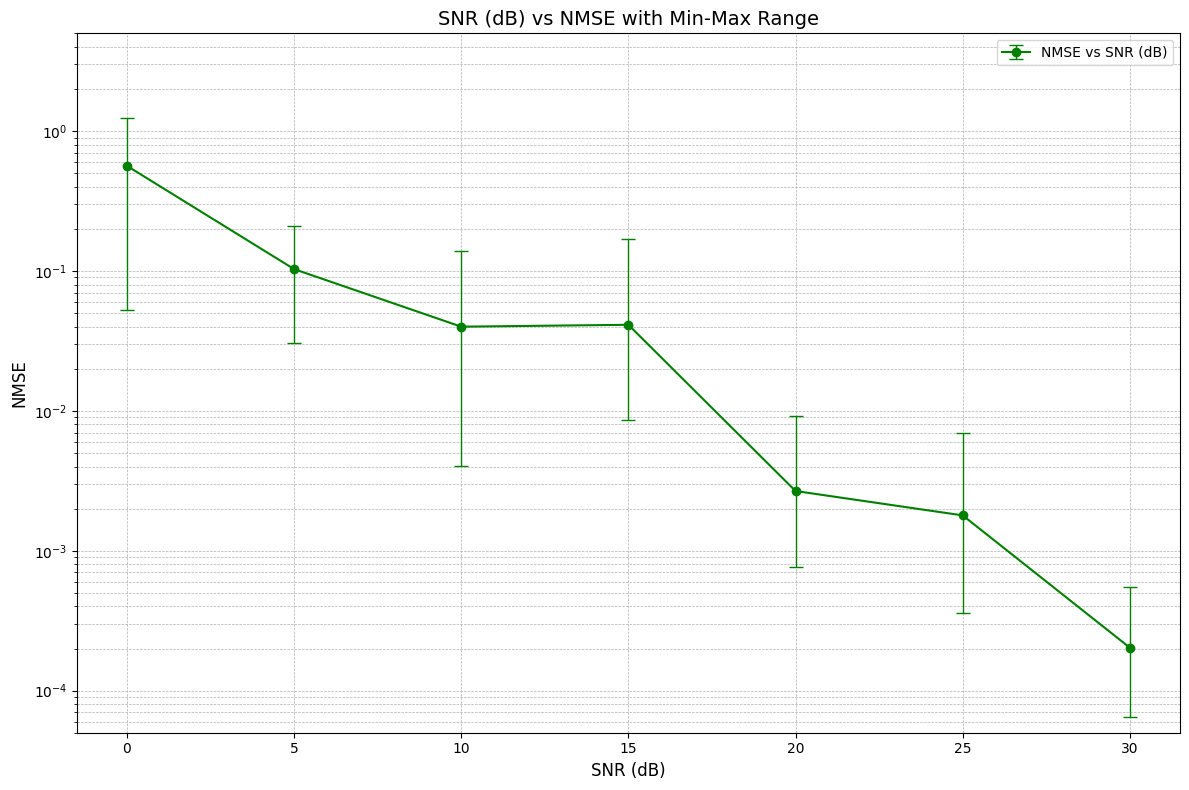

In [205]:
# Convert dictionary data to lists for plotting
snr = list(NMSE_mean_dict.keys())
nmse_mean = list(NMSE_mean_dict.values())
nmse_max = list(NMSE_max_dict.values())
nmse_min = list(NMSE_min_dict.values())

# Calculate the error bars from mean to min/max
yerr_low = np.array(nmse_mean) - np.array(nmse_min)
yerr_high = np.array(nmse_max) - np.array(nmse_mean)

# Plotting
plt.figure(figsize=(12, 8))
plt.errorbar(snr, nmse_mean, yerr=[yerr_low, yerr_high], marker='o', linestyle='-', color='g',
            label='NMSE vs SNR (dB)', capsize=5, elinewidth=1, capthick=1)
plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('NMSE', fontsize=12)
plt.title('SNR (dB) vs NMSE with Min-Max Range', fontsize=14)

# Set y-axis to logarithmic scale
plt.yscale('log')
# Set explicit y-axis limits
plt.ylim(5e-5, 0.5e1)  # Adjusted for better visualization

plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # Grid for both major and minor ticks
plt.legend()
plt.tight_layout()
plt.show()